# 0211 - Data preprocessing
- 대용량 데이터를 효율적으로 처리할수 있는 파이프라인 구축 및 데이터 전처리 시도 3


- generator를 사용하되, 각 레이블 csv 파일을 섞어가며 배치데이터를 생성  


In [8]:
# import libraries

import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [2]:
# Define the directory containing the CSV files
train_directory = "../data/train_simplified"

# Get the list of CSV files in the directory
csv_files = [os.path.join(train_directory, file) for file in os.listdir(train_directory) if file.endswith(".csv")]

# check csv files list
print('csv 파일 수 : ', len(csv_files))
print('csv_files[:3] : ', csv_files[:3])

csv 파일 수 :  340
csv_files[:3] :  ['../data/train_simplified/cruise_ship.csv', '../data/train_simplified/coffee_cup.csv', '../data/train_simplified/spreadsheet.csv']


In [3]:
# train_simplified 폴더 내의 파일 목록
train_csvs = [file for file in os.listdir(train_directory) if file.endswith('.csv')]
print("train_simplified 폴더 내 파일 수:", len(train_csvs))
print('train_csvs[:3] : ',train_csvs[:3])

# .csv 확장자를 제외한 파일명을 사용하여 label_names 리스트를 생성
label_names = [file.replace('.csv', '') for file in train_csvs]
print('label_names [:3] :', label_names[:3])

# label_names 리스트의 총 개수를 출력
print("label_names의 총 개수:", len(label_names))

train_simplified 폴더 내 파일 수: 340
train_csvs[:3] :  ['cruise_ship.csv', 'coffee_cup.csv', 'spreadsheet.csv']
label_names [:3] : ['cruise_ship', 'coffee_cup', 'spreadsheet']
label_names의 총 개수: 340


---

# try 1 :  `ShuffledDataGenerator` 코드 수정

- `ShuffledDataGenerator` 클래스(셔플클래스)는 **row** 를 yield함
- dataset을 만들기위한 `tf.data.Dataset.from_generator`를 사용할수 없는 문제 발생 
- `ImgDataGenerator` 코드를 차용해서 셔플클래스를 수정해보려고함


## step 1 - ShuffledDataGenerator에 ImgDataGenerator 기능 추가

- '__getitem__' method를 추가해야함

In [4]:
import json
from tensorflow.keras.utils import Sequence, to_categorical

class ShuffledDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, label_paths, batch_size, shuffle_within_label=True, input_shape=(128, 128, 3), label_names=None, lw=3, smoothing_factor=0.1):
        """
        ShuffledDataGenerator 클래스 생성자
        
        Args:
            label_paths (list): 각 레이블 CSV 파일 경로의 리스트
            batch_size (int): 배치 크기
            shuffle_within_label (bool): 각 레이블의 데이터셋 내에서 섞을지 여부
            input_shape (tuple): 입력 이미지 모양 (기본값: (128, 128, 3))
            label_names (list): 레이블 이름 리스트 (기본값: None)
            lw (int): 선의 너비 (기본값: 3)
            smoothing_factor (float): 스무딩 팩터 (기본값: 0.1)
        """
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.shuffle_within_label = shuffle_within_label
        self.input_shape = input_shape  # 입력 이미지 모양
        self.label_names = label_names  # 레이블 이름
        self.lw = lw                    # 선의 너비
        self.smoothing_factor = smoothing_factor  # 스무딩 팩터
        self.file_generators = [self._file_generator(label_path) for label_path in label_paths]
        self.indices = np.arange(len(self.file_generators)).repeat(batch_size)
        
        if shuffle_within_label:
            self._shuffle_within_label()

    def __len__(self):
        """
        제네레이터 내의 배치 수 리턴
        """
        return len(self.indices) // self.batch_size
    
    # 레이블을 부드럽게 만드는 함수
    def smooth_labels(self, labels):
        labels *= (1 - self.smoothing_factor) # 스무딩 적용
        labels += (self.smoothing_factor / len(self.label_names))  # 스무딩 팩터에 따라 레이블 조정
        return labels
    

    def __getitem__(self, idx):
        """
        데이터의 배치 생성
        
        Args:
            idx (int): 배치 인덱스
        
        Returns:
            tuple: (X_batch, y_batch) data tuple
        """
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, y_batch = [], []
        for i in batch_indices:
            data_generator = self._file_generator(self.label_paths[i])
            X, y = next(data_generator)
            X_batch.append(X)
            y_batch.append(y)
        return np.array(X_batch), np.array(y_batch)

    
    def _file_generator(self, label_path):
        """
        각 레이블 CSV 파일에서 데이터를 생성
        
        Args:
            label_path (str): 각 레이블 CSV 파일 경로
        
        Yields:
            tuple: (X, y) 데이터 튜플
        """
        df = pd.read_csv(label_path, usecols=['drawing','word'])
        
#         print("Number of rows in DataFrame:", len(df)) # debugging
        
        if self.shuffle_within_label:
            df = df.sample(frac=1)  # 레이블의 데이터셋 내에서 섞기

        h, w, ch = self.input_shape     # 이미지 모양     
        X = np.zeros((self.batch_size, h, w, ch))  # 입력 이미지 배열 초기화
        y = np.zeros((self.batch_size, len(self.label_names)))  # 레이블 배열 초기화

#         '''debugging'''
#         print(f"X shape: {X.shape}")  
        
        for (_, row) in df.iterrows():  # DataFrame의 각 행을 생성
#             '''debugging'''
#             print(f"Processing index: {i}") 
            
            # drawing 정보 처리
            raw_strokes = json.loads(row['drawing'])   # 그림 정보 가져오기
            
#             '''debugging'''
#             print('raw_strikes: ', raw_strokes) 
            
            X = draw_strokes(raw_strokes, image_size=h, line_width=self.lw)

            # word 정보 처리 
            word = row['word'].replace(' ', '_')  # 레이블 인덱스 (공백을 underscore _ 로 변경)
            label_index = self.label_names.index(word)  # map word to numerical index
            y = to_categorical(label_index, num_classes=len(self.label_names))  # 원-핫 인코딩된 레이블

#         '''debugging'''
#         print(f"Generated X :{X} and y :{y}") 
            
        yield (X, y)

    
    def _shuffle_within_label(self):
        """
        각 레이블의 데이터셋 내에서 인덱스를 섞기
        """
        np.random.shuffle(self.indices)

---
### drawing 컬럼의 좌표값으로 이미지를 그리는 함수(승순님 코드)

- 이 함수는 `raw_strokes` (원시 획 데이터)를 입력으로 받아, 지정된 이미지 크기(`image_size`)와 선 두께(`line_width`)를 사용하여 이미지를 생성합니다. 
- 입력된 획 데이터는 NumPy 배열로 변환되며, 각 획의 최소 및 최대 x, y 좌표를 계산하여 이미지의 경계를 결정합니다. 
- 이후, 계산된 비율에 따라 모든 획의 좌표를 조정하고, OpenCV의 `cv2.line` 함수를 사용하여 선을 그립니다. 
- 최종적으로 조정된 좌표에 따라 그려진 이미지를 반환합니다. 
- 이 과정을 통해, 원본파일의 drawings 컬럼의 좌표값 데이터(stroke)를 이미지형태로 변환할 수 있습니다.

In [60]:
# def draw_strokes(raw_strokes, image_size=128, line_width=6):
#     border_offset = line_width * 2  # 테두리 공백 크기
#     stroke_list = []  # raw_strokes를 NumPy 배열로 변환한 리스트
#     bounds_info = {"min_x": float('inf'), "min_y": float('inf'),  # 최소 x, y 좌표 초기화
#                    "max_x": float('-inf'), "max_y": float('-inf')}  # 최대 x, y 좌표 초기화
    
#     # raw_strokes의 각 stroke에 대해 NumPy 배열로 변환하고 경계 좌표 갱신
#     for stroke in raw_strokes:
#         np_stroke = np.array(stroke)  # stroke를 NumPy 배열로 변환
#         stroke_list.append(np_stroke)    # 변환된 배열을 stroke_list에 추가
#         # 최소/최대 x, y 좌표 갱신
#         bounds_info["min_x"] = min(bounds_info["min_x"], min(np_stroke[0]))
#         bounds_info["max_x"] = max(bounds_info["max_x"], max(np_stroke[0]))
#         bounds_info["min_y"] = min(bounds_info["min_y"], min(np_stroke[1]))
#         bounds_info["max_y"] = max(bounds_info["max_y"], max(np_stroke[1]))
    
#     # 빈 이미지 생성
#     new_image = np.zeros((image_size, image_size, 3), dtype=float)
#     original_width = bounds_info["max_x"] - bounds_info["min_x"]  # 원본 그림의 너비
#     original_height = bounds_info["max_y"] - bounds_info["min_y"]  # 원본 그림의 높이
#     ratio = max(original_width, original_height) / (image_size - border_offset * 2)  # 비율 계산
    
#     # 비율이 0일 경우 빈 이미지 반환
#     if ratio == 0:
#         return new_image

#     # 각 stroke의 좌표를 새로운 크기에 맞게 조정하여 이미지에 그리기
#     for np_stroke in stroke_list:
#         np_stroke[0] = (np_stroke[0] - bounds_info["min_x"]) / ratio + border_offset  # x 좌표 조정
#         np_stroke[1] = (np_stroke[1] - bounds_info["min_y"]) / ratio + border_offset  # y 좌표 조정
#         # 선 그리기
#         for i in range(len(np_stroke[0]) - 1):
#             start_x, start_y = int(np_stroke[0][i]), int(np_stroke[1][i])  # 시작점 좌표
#             end_x, end_y = int(np_stroke[0][i + 1]), int(np_stroke[1][i + 1])  # 끝점 좌표
#             new_image = cv2.line(new_image, (start_x, start_y), (end_x, end_y), (255, 255, 255), line_width)  # 선 그리기
    
#     print(new_image) # debugging
    
#     return new_image  # 완성된 이미지 반환

- error가 계속 나서 함수 새로 생성

In [5]:
def draw_strokes(raw_strokes, image_size=128, line_width=3):
    """
    Function to draw strokes based on coordinates
    
    Args:
        raw_strokes (list): List of strokes with coordinates
        image_size (int): Size of the image (default: 128)
        line_width (int): Width of the line (default: 3)
    
    Returns:
        ndarray: Array representing the drawn image
    """
    image = np.zeros((image_size, image_size))
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            x0, y0 = stroke[0][i], stroke[1][i]
            x1, y1 = stroke[0][i + 1], stroke[1][i + 1]
            cv2.line(image, (x0, y0), (x1, y1), 1, line_width)

    return image

In [6]:
# Img_data_generator 인스턴스 생성
input_shape = (128, 128, 3)  # 입력 이미지의 형태 
batch_size = 32              # 배치 사이즈
lw = 3
smoothing_factor = 0.1
"""
ShuffledDataGenerator 클래스의 인스턴스 생성
- csv_files : 각 레이블 CSV 파일 경로의 리스트
- batch_size (int): 배치 크기
- shuffle_within_label (bool): True - 각 레이블의 데이터셋 내에서 섞을지 여부
- input_shape: 입력 이미지의 형태 (높이, 너비, 채널 - 기본값: (128, 128, 3))
- label_names: 레이블 이름 리스트
- lw: 선의 너비 (기본값은 2)
- smoothing_factor (float): 스무딩 팩터 (기본값: 0.1)
"""
shuffled_data_gen = ShuffledDataGenerator(csv_files, batch_size, input_shape=input_shape, label_names=label_names, lw=lw, smoothing_factor=smoothing_factor)

In [9]:
shuffled_data_gen[0]

KeyboardInterrupt: 

NameError: name 'data_gen' is not defined

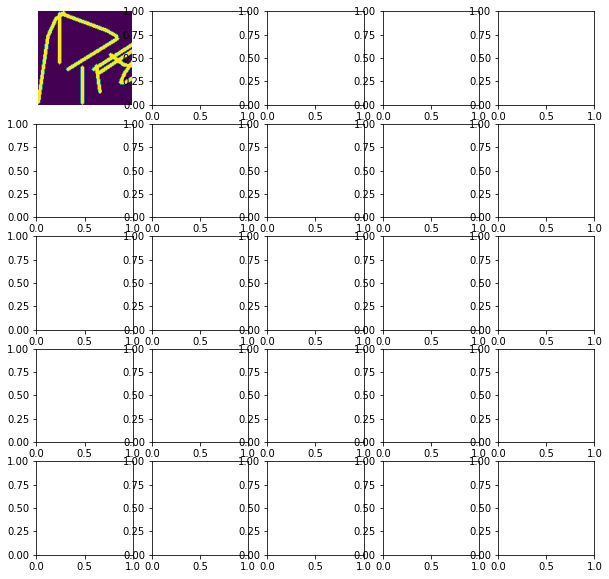

In [10]:
# === shuffled_data_gen test ===

# 첫 번째 배치 데이터 가져오기 및 시각화
xx, y = shuffled_data_gen[0]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
labels = np.argmax(y, axis=1)  # 레이블 인덱스

# 이미지를 0에서 1 사이의 값으로 변환
xx = xx.astype(float) / 255.0

# 5x5 그리드에서 각 셀에 대해 이미지를 시각화하는 반복문
for i in range(25):
    axs[i // 5, i % 5].imshow(xx[i])  # 이미지 플로팅
    axs[i // 5, i % 5].axis('off')  # 축 숨기기
    axs[i // 5, i % 5].set_title(shuffled_data_gen.label_names[labels[i]])  # 레이블 이름 설정

plt.show()

In [11]:
# 5x5 그리드에서 각 셀에 대해 이미지를 시각화하는 반복문
for i in range(25):
    axs[i // 5, i % 5].imshow(xx[i])  # 이미지 플로팅
    axs[i // 5, i % 5].axis('off')  # 축 숨기기
    axs[i // 5, i % 5].set_title(shuffled_data_gen.label_names[labels[i]])  # 레이블 이름 설정

plt.show()

Generated X :[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] and y :[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

KeyboardInterrupt: 

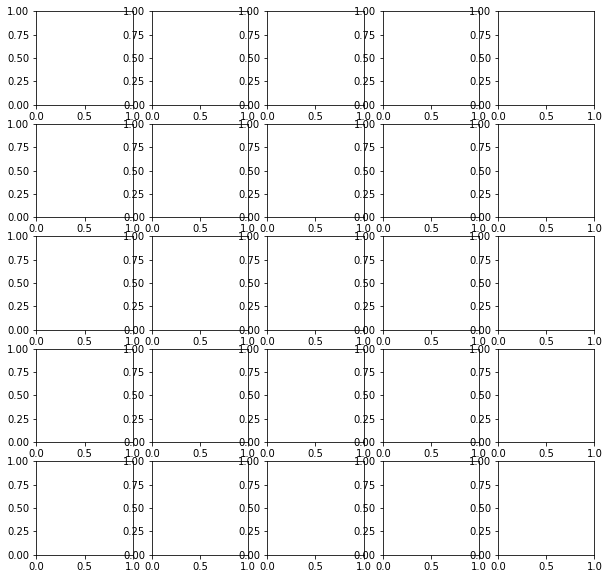

In [101]:
# # === shuffled_data_gen test ===

# # Define the number of rows and columns for the plot grid
# num_rows = 5
# num_cols = 5
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# generator_list = shuffled_data_gen[0]

# # Iterate over each generator object in the list
# for generator_object in generator_list:
#     # Extract data from the generator
#     batch_data = next(generator_object)

#     print(batch_data)
    
# #     # Visualize the images and labels
# #     for (X, y) in batch_data:
# #         for i in range(len(X)):
# #             plt.imshow(X[i])
# #             plt.title(label_names[np.argmax(y[i])])
# #             plt.show()

- shuffled_data_gen이 generator를 반환하는데 이걸 시각화하는게 잘 되지않는다.
- 일단 이 제너레이터로 원래 하려고했던 tf.data.Dataset.from_generator 데이터셋 생성

## step 2 - from_generator로 데이터셋 생성
- `watch -n 1 nvidia-smi` 로 터미널에서 메모리 사용량 체크 
    - 여기까지 256MiB/15109MiB 사용
- `%%time` 매직 명령 사용해서 해당 셀의 실행시간 체크
    - 34초 걸림

In [102]:
%%time

# Create a TensorFlow dataset using from_generator method
dataset = tf.data.Dataset.from_generator(
    lambda: shuffled_data_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Image tensor
        tf.TensorSpec(shape=(None, len(label_names)), dtype=tf.int16)  # Label tensor
    )
)

# shuffle and prefetch the dataset
dataset = dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# dataset check
for images, labels in dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

InvalidArgumentError: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.int16), but the yielded element was [<generator object ShuffledDataGenerator._file_generator at 0x7f4af507f820>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f190>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fd60>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f5f0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f900>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fba0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f970>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fa50>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f6d0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fcf0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f510>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f740>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fe40>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fc80>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507ff20>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f660>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fb30>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fdd0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507feb0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507ff90>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe040>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe0b0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe120>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe190>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe200>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe270>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe2e0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe350>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe3c0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe430>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe4a0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe510>].
Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 898, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/util/nest.py", line 381, in flatten_up_to
    assert_shallow_structure(shallow_tree, input_tree)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/util/nest.py", line 282, in assert_shallow_structure
    raise TypeError(

TypeError: If shallow structure is a sequence, input must also be a sequence. Input has type: <class 'list'>.


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 900, in generator_py_func
    six.reraise(

  File "/opt/conda/lib/python3.9/site-packages/six.py", line 718, in reraise
    raise value.with_traceback(tb)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 898, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/util/nest.py", line 381, in flatten_up_to
    assert_shallow_structure(shallow_tree, input_tree)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/util/nest.py", line 282, in assert_shallow_structure
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.int16), but the yielded element was [<generator object ShuffledDataGenerator._file_generator at 0x7f4af507f820>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f190>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fd60>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f5f0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f900>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fba0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f970>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fa50>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f6d0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fcf0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f510>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f740>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fe40>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fc80>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507ff20>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507f660>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fb30>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507fdd0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507feb0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af507ff90>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe040>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe0b0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe120>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe190>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe200>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe270>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe2e0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe350>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe3c0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe430>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe4a0>, <generator object ShuffledDataGenerator._file_generator at 0x7f4af4bfe510>].


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

---

# 정리

- draw_strokes 함수 코드가 제대로 되지 않은 것같음
- 승순님 파이프라인에서 tf.data 을 사용하는 코드 시도